# Exploratory Analysis of DMPS Data

[DMPS](https://eogdata.mines.edu/dmsp/downloadV4composites.html) provides cloud-free composites made using all the available archived DMSP-OLS smooth resolution data for calendar years 1994-2013. 

To do an exploratory analysis we pull two files one for 1994 and one for 2013. This will allow for comparitive analysis.

* We have a downloader script available that can download and untar the the files so that we can then proceed with reading in the images.
* The files are large in size with avg size being around 300MB


### importing required libraries

In [23]:
import numpy as np
import pandas as pd
from glob import glob
import pathlib
import os
import matplotlib.pyplot as plt
from plotnine import *
import re

#### Helper function to read a particular TIF image

In [2]:
import rasterio
from rasterio.plot import show


def get_image(path):
    p = path #"data\F182013.v4\F182013.v4c_web.avg_vis.tif\F182013.v4c_web.avg_vis.tif"
    fp = os.path.abspath(os.path.join( "./../../", p))
    src = rasterio.open(fp)
    img = src.read(1)
    #fig, ax = plt.subplots(figsize=(18, 10))
    #ax.imshow(img[4000:9000 , 28000:35000 ], cmap='pink')
    return img
    #show(img)

#### Reading in 2013 and 1994 images

In [3]:
im2013 = get_image("data\F182013.v4\F182013.v4c_web.avg_vis.tif\F182013.v4c_web.avg_vis.tif")

In [4]:
im1994 = get_image("data\F101994.v4\F101994.v4b_web.avg_vis.tif\F101994.v4b_web.avg_vis.tif")

Let's first plot the raw 2013 image composite

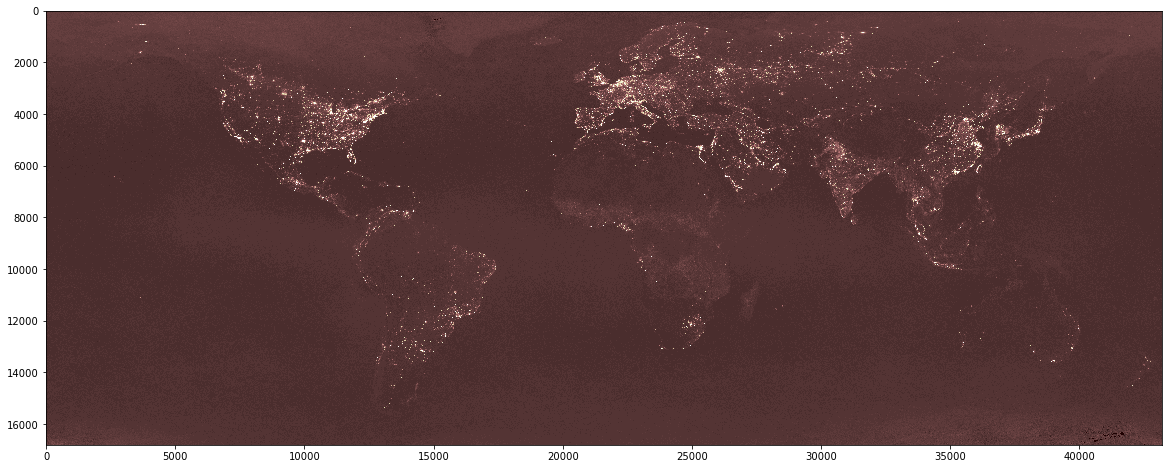

In [5]:
f,ax = plt.subplots(1,1 ,figsize=(20,8))
ax.imshow(im2013.astype(np.byte) , cmap='pink' )

We see a lot of 'haziness' in the image. We can get a sense of the spread of the image intensity values using the quantile method

In [6]:
np.quantile(im2013 , np.arange(0,1,0.1))

array([0., 3., 3., 3., 3., 4., 4., 4., 4., 5.])

We see that most of the values in the image are less than 5. Since the image is mostly black/dark this is reasonable and therefore we can do quick thresholding to reveal the night light intensities that we are interested in. We pick a number larger than 5 ,  10 in the case below.

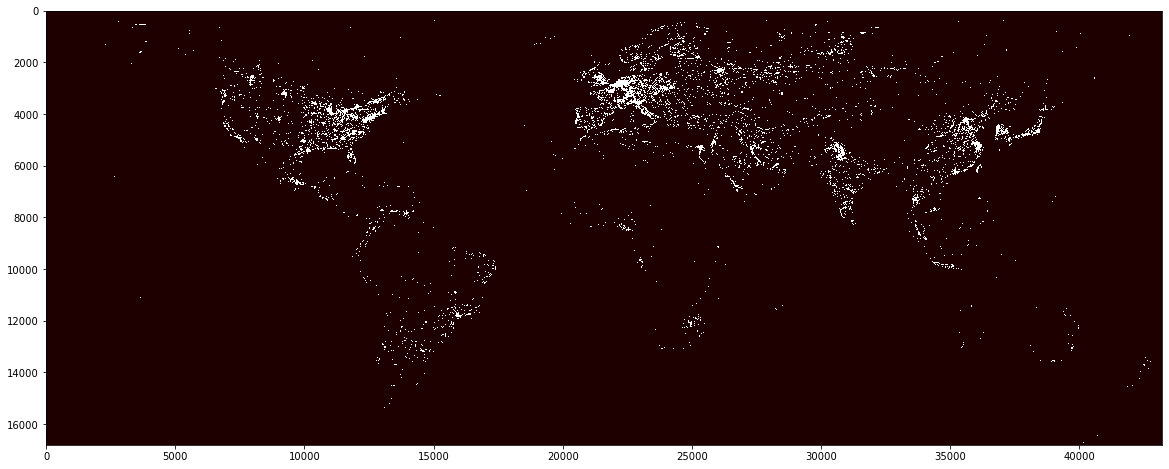

In [7]:
f,ax = plt.subplots(1,1 ,figsize=(20,8))
ax.imshow(im2013 > 10 , cmap='pink')

Now the night light intensities are better visible and the haziness goes away.

### Aggregating

Before we begin aggregating the nightlights, we should take a look at the image size to get an estimate on the performance of any aggregation.

In [8]:
im2013.shape

(16801, 43201)

We see that the image is very high dimensional and therefore we should rely on numpy broadcasting when doing any aggregation as that will allow for parallel execution of the operations.

In the aggregation below we divide the image in 100x100 blocks and for each patch we first threshold ( > 10) and then calculate the sum of the pixel intensities

c:\users\abhijeet\documents\github\datathon\dt\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


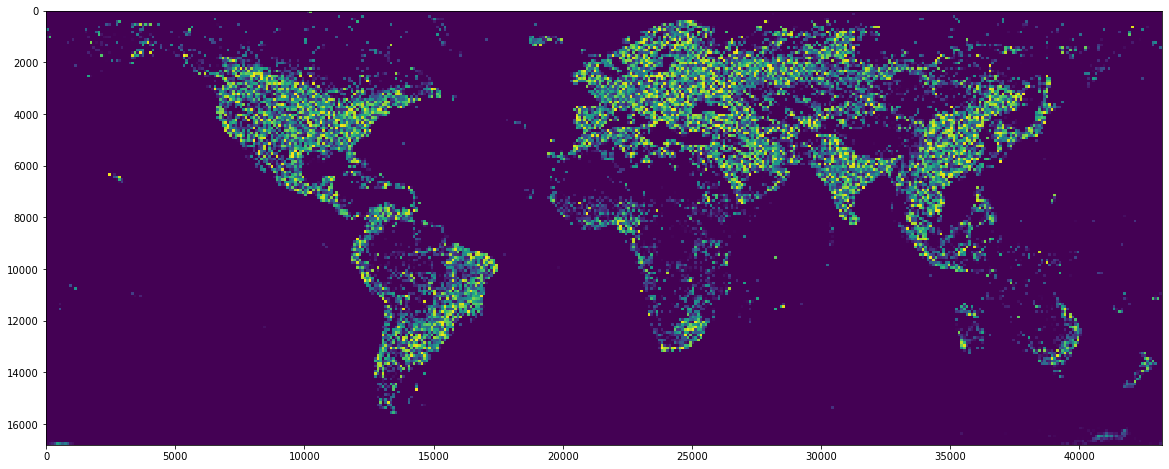

In [22]:
pim2013 = np.copy(im2013)
ist = 100
jst = 100
for i in np.arange(0,pim2013.shape[0],ist):
    for j in np.arange(0,pim2013.shape[1], jst):
        patch = pim2013[i:i+ist , j:j+jst]
        val = (patch > 10).sum() #/ (ist * jst)
        #print(val)
        pim2013[i:i+ist , j:j+jst] = val

patch = patch/ patch.max()
f,ax = plt.subplots(1,1 ,figsize=(20,8))
ax.imshow(pim2013)

In the image above we can see that the brightly lit areas turned yellow and the darker regions are black, while green/blue represents in between intensities.

One thing to notice for our analysis is that certain parts of the world (land) like saharan africa , amazon forest , australian wasteland are almost as dark as the oceans , indicating little to no human activities.

### Zooming In

Let's go a step further and extract a particular country - India. Since this is only an exploratory analysis, we can use crude numpy accessors to focus in. Looking at the image axes above we can see that roughly the region translates to 4000 to 9000 in the vertical direction and 28000 to 35000 in the horizontal direction.

Let's extract indian subcontinent in both the 2013 and the 1994 images. 

In [49]:
def india_selector(img):
    return img[4500:8500 , 29500:33000]

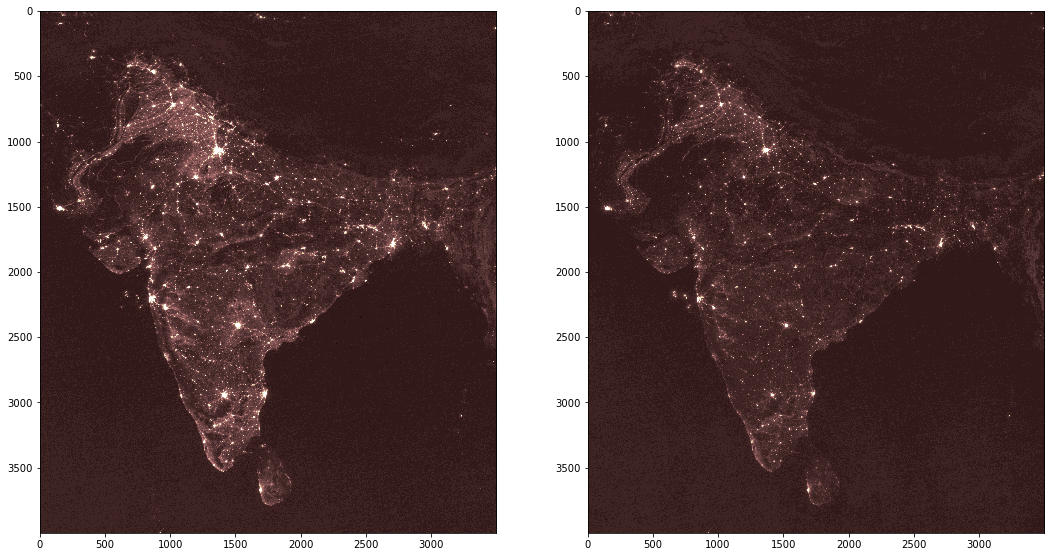

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(18, 10))
ax1.imshow(india_selector(im2013) , cmap='pink')
ax2.imshow(india_selector(im1994), cmap='pink')

The right image above is from 1994 and the left one from 2013. We can clearly see that in 20years the region has gotten brighter specially in regions which were futher away from the brighter spots of 1994.

To get a better sense of the change let's look at the spread of the intensities.


In [53]:
ind2013 = india_selector(im2013)
ind1994= india_selector(im1994)

In [54]:
np.quantile(ind2013.flatten() , np.arange(0,1,0.25))

array([2., 3., 4., 4.])

In [55]:
np.quantile(ind1994.flatten() , np.arange(0,1,0.25))

array([1., 2., 2., 3.])

We can do better visually

C:\Users\Abhijeet\Documents\GitHub\Datathon\dt\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 74'. Pick better value with 'binwidth'.


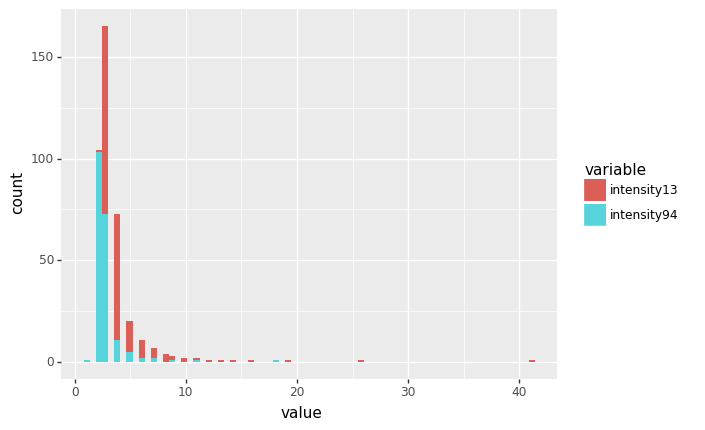

<ggplot: (143630635577)>

In [68]:
intdf = pd.DataFrame({
        "intensity94" : np.quantile(ind1994.flatten() , np.arange(0,1,0.005)) 
    ,   "intensity13" : np.quantile(ind2013.flatten() , np.arange(0,1,0.005)) 
    })


(
    ggplot(intdf.reset_index().melt(id_vars='index'), aes(x="value" , fill="variable"))
    + geom_histogram()
)

We see that for the year 2013 compared to 1994 there are more pixels with higher intensity values.

To futher understand the change let's zoom in a bit further to Mumbai metropolitan area. Using the same logic as above we can index into the numpy array and extract the 2013 and 1994 images.

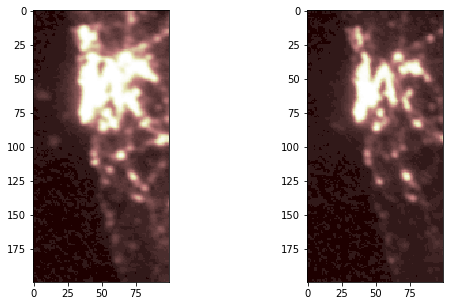

In [202]:
mumbai2013 = india_selector(im2013)[2650:2850 , 2300:2400]
mumbai1994 = india_selector(im1994)[2650:2850 , 2300:2400]
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(9, 5))
ax1.imshow(mumbai2013 , cmap='pink')
ax2.imshow(mumbai1994, cmap='pink')

Visually we can see the difference but to quantify it let's look at the quantiles of the pixel intensities.

In [203]:
np.quantile(mumbai2013.flatten() , np.arange(0,1,0.25))

array([ 3.,  4.,  6., 13.])

In [204]:
np.quantile(mumbai1994.flatten() , np.arange(0,1,0.25))

array([2., 3., 4., 7.])

We can see that the 75%tile values have almost doubled in 20 years! And this is without any sort of thresholding.
We can try different thresholded values to extract clusters from the region. 
But before we do that we can also apply an image filter to sharpen the image a bit. This should help magnify the intensity values.

We use the `ImageFilter` from `PIL` library to achieve that.

In [205]:
from PIL import ImageFilter, Image

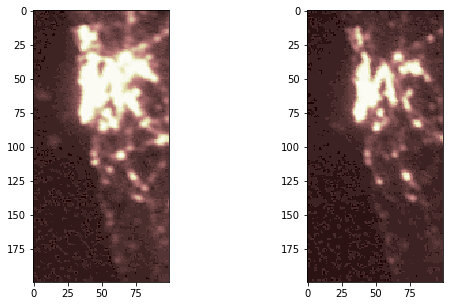

In [206]:
mumbai2013 = Image.fromarray(india_selector(im2013)[2650:2850 , 2300:2400]).filter(ImageFilter.SHARPEN)
mumbai1994 = Image.fromarray(india_selector(im1994)[2650:2850 , 2300:2400]).filter(ImageFilter.SHARPEN)
fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(9, 5))
ax1.imshow(mumbai2013 , cmap='pink')
ax2.imshow(mumbai1994, cmap='pink')

In [207]:
np.quantile(np.array(mumbai2013).flatten() , np.arange(0,1,0.25))

array([ 2.,  4.,  6., 13.])

In [208]:
np.quantile(np.array(mumbai1994).flatten() , np.arange(0,1,0.25))

array([1., 3., 4., 7.])

We can see that this helped , abliet only a tiny bit. Let's get to trying different threshold values.

We try a range of values from `0 to 13`

#### Thresholding

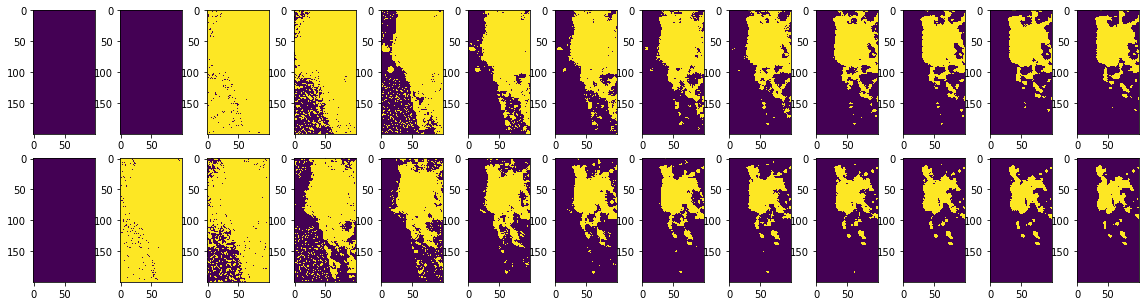

In [209]:
fig,ax = plt.subplots(2,13 , figsize=(20,5))
for i in range(0,13):
    ax[0][i].imshow(np.array(mumbai2013) > i)
    ax[1][i].imshow(np.array(mumbai1994) > i)

The above array of images has 2013 images on the first row , 1994 images at the bottom.

From left to right we have an increasing value of the threshold `0 to 13`.

What we can see is that the cluster that we get, changes drastically as we increase the threshold values. 

#### Therefore in our further analysis it is going to be crucial to see if we can learn the threshold from data using economic indicators downloaded from the IMF/WHO.

### GDP Data

Let's load the gdp data and take a look at that. The data available is at the country level. Our goal is to be able to train the model at the country level and then hopefully we will be able to make predictions at subnational level as well.


In [17]:
gdp = pd.read_csv("./../../data/gdp.csv")

In [18]:
gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.549721e+09,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,537777811.1,548888895.6,546666677.8,751111191.1,800000044.4,1.006667e+09,...,1.780429e+10,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.936264e+10,2.019176e+10,1.948438e+10,1.910135e+10,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.117900e+11,1.280530e+11,1.367100e+11,1.457120e+11,1.161940e+11,1.011240e+11,1.221240e+11,1.013530e+11,9.463542e+10,NaN
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.289077e+10,1.231983e+10,1.277622e+10,1.322814e+10,1.138685e+10,1.186120e+10,1.301969e+10,1.514702e+10,1.527808e+10,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.629204e+09,3.188809e+09,3.193704e+09,3.271808e+09,2.789870e+09,2.896679e+09,3.000181e+09,3.218316e+09,3.154058e+09,NaN


It looks like we have data starting from 1960 till 2020. Let's focus on a few developing and a few developed nations

In [19]:
high = ["United States","United Kingdom" , "Germany" , "China"]
low = ["India" , "Bangladesh" , "Vietnam"]

In [24]:
selected_df = gdp[gdp["Country Name"].isin(high + low)].melt(id_vars="Country Name" , value_vars=np.arange(1960, 2020).astype(str))
selected_df

,Country Name,variable,value
0,Bangladesh,1960,4.274894e+09
1,China,1960,5.971647e+10
2,Germany,1960,NaN
3,United Kingdom,1960,7.323397e+10
4,India,1960,3.702988e+10
...,...,...,...
415,Germany,2019,3.845630e+12
416,United Kingdom,2019,2.827110e+12
417,India,2019,2.875140e+12
418,United States,2019,2.137440e+13


Let's look at the data visually to get a sense of the trends these countries are following

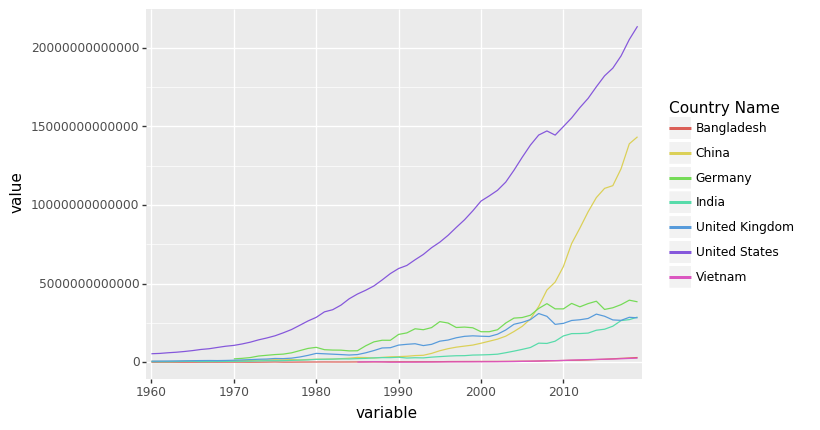

<ggplot: (143619665654)>

In [26]:
(
    ggplot(selected_df , aes(x="variable" , y="value" , color="Country Name" , group="Country Name"))
    + geom_line()
    + scale_x_discrete(breaks = selected_df["variable"].unique()[::10])
)

We see that the US has been rapidly growing since late 1970s and is the largest economy by far. 
We can also see that China, since late 2000s has picked up pace and gone from 5T to almost 15T in a short span of 10 years.

While we see small developing nations like Bangladesh and Vietnam have much smaller economies compared to these giants and there gdp curves show up as almost flat lines.

Let's go back to our earlier question of night light intensities and GDP. We had seen that compared to 1994, India's nighttime lights had grown in intensity by 2013. Let's see what the GDP numbers tell us about the same timeframe.

In [32]:
g94, g13 = gdp[gdp["Country Name"] == "India"][["1994" , "2013"]].values[0]

In [34]:
g13/g94

5.673254378567325

We see that by 2013 , India's GDP became 5 times of what it was in 1994. In our project we will try to predict the gdp/gdp growth using satellite images including the night light intensities and/or the land use patterns.